Max absolute difference between analytical solution and TensorFlow DNN =  0.016352445993368044


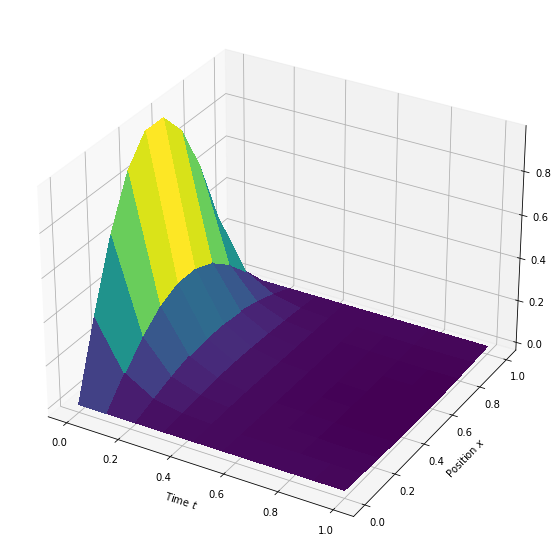

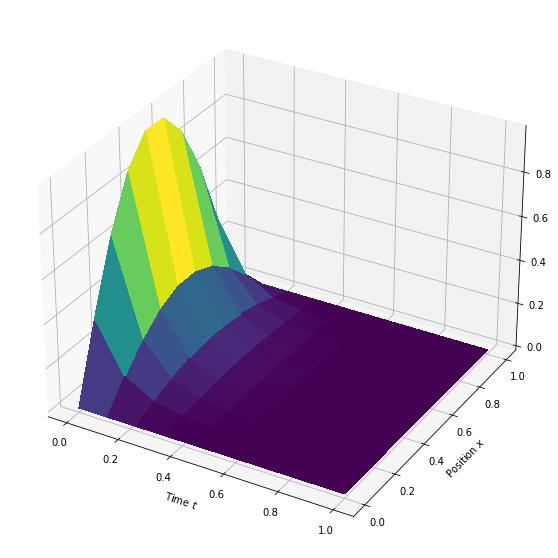

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from tensorflow.keras.models import Sequential      #This allows appending layers to existing models
from tensorflow.keras.layers import Dense           #This allows defining the characteristics of a particular layer
from tensorflow.keras import optimizers             #This allows using whichever optimiser we want (sgd,adam,RMSprop)
tf.keras.backend.set_floatx('float64')

def loss(model, x, t):
    with tf.GradientTape() as tape_x2:
        tape_x2.watch([x])
        with tf.GradientTape() as tape_x, tf.GradientTape() as tape_t:
            tape_x.watch([x])
            tape_t.watch([t])
            g_trial = (1 - t) * tf.sin(np.pi * x) + x * (1 - x) * t * model(tf.concat([x,t], 1))

        dg_dx = tape_x.gradient(g_trial, x)
        dg_dt = tape_t.gradient(g_trial, t)

    dg_d2x = tape_x2.gradient(dg_dx, x)

    return tf.losses.mean_squared_error(zeros, dg_d2x - dg_dt)

def train(model, optimizer, x, t):
    with tf.GradientTape() as tape:
        current_loss = loss(model, x, t)
        
    grads = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

# Setting up data
Nx = 10
Nt = 10

x_np = np.linspace(0, 1, Nx)
t_np = np.linspace(0, 1, Nt)

X, T = np.meshgrid(x_np, t_np)

x = X.ravel()
t = T.ravel()

zeros = tf.reshape(tf.convert_to_tensor(np.zeros(x.shape)), shape=(-1,1))
x = tf.reshape(tf.convert_to_tensor(x), shape=(-1,1))
t = tf.reshape(tf.convert_to_tensor(t), shape=(-1,1))

# Setting up model
model = Sequential()
model.add(Dense(20, activation='sigmoid'))
model.add(Dense(1, activation="linear"))
model.build(tf.concat([x,t], 1).shape)

eta = 0.001
sgd = optimizers.SGD(lr=eta)

# Training model
num_iter = 100000
for i in range(num_iter):
    train(model, sgd, x, t)
    
# Output of model
g_dnn = (1 - t) * tf.sin(np.pi * x) + x * (1 - x) * t * model(tf.concat([x,t], 1))
G_dnn = np.array(g_dnn).reshape((Nt, Nx))

g_analytic = tf.exp(-np.pi**2 * t) * tf.sin(np.pi * x)
G_analytic = np.array(g_analytic).reshape((Nt, Nx))

# Plot the results
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
s = ax.plot_surface(T, X, G_dnn, linewidth=0, antialiased=False, cmap=cm.viridis)
ax.set_xlabel('Time $t$')
ax.set_ylabel('Position $x$')

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
s = ax.plot_surface(T, X, G_analytic, linewidth=0, antialiased=False, cmap=cm.viridis)
ax.set_xlabel('Time $t$')
ax.set_ylabel('Position $x$')

## Compare with the analutical solution
diff = np.abs(g_analytic - g_dnn)
print('Max absolute difference between analytical solution and TensorFlow DNN = ', np.max(diff))